#  Resume

In this case study, we shall try to extract important information from resume.  This case study usefulness is not limited to resume though, i.e., legal documents, stock documents, medical documents, etc.

We will be using two datasets; the first contains resume texts and the second contains skills that we will use to create an entity ruler.

## 1. Load Data

### 1.1 Resume Dataset

A collection of 2400+ resume Examples taken from livecareer.com (https://www.kaggle.com/datasets/snehaanbhawal/resume-dataset)

-`ID`: Unique identifier and file name for the respective pdf.

-`Resume_str` : Contains the resume text only in string format.

-`Resume_html` : Contains the resume data in html format as present while web scrapping.

-`Category` : Category of the job the resume was used to apply, e.g., HR, Designer.

In [1]:
import pandas as pd
import numpy as np

df_resume = pd.read_csv("../data/resume.csv")

In [2]:
#randomized Job categories so that 200 samples contain various job categories instead of one.
df_resume = df_resume.reindex(np.random.permutation(df_resume.index))

# limit our number of samples to 200 as processing 2400+ takes time.
df_resume = df_resume.copy().iloc[0:200,]

In [3]:
df_resume.head()

,ID,Resume_str,Resume_html,Category
1639,16605640,ADMINISTRATIVE ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL
708,11653906,SENIOR DIRECTOR OF BUSINESS OPERATION...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE
2291,12777487,ONLINE LEARNING COORDINATOR - PROGRAM...,"<div class=""fontsize fontface vmargins hmargin...",ARTS
2329,39608848,MARKETING MANAGER Summary To...,"<div class=""fontsize fontface vmargins hmargin...",ARTS
2309,37472265,4/5 GRADE TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ARTS


In [4]:
df_resume.shape

(200, 4)

In [5]:
#sample sentence
df_resume.Resume_str.values[:1][0][:200]

'         ADMINISTRATIVE ASSISTANT       Summary     Experienced Administrative Assistant with extensive background providing support to college Dean of Student Success, Associate Vice President of Stu'

### 1.2 Load Data - Skill Patterns Dataset
Skills dataset

The jobzilla skill dataset is `jsonl` file containing different skills that can be used to create spaCy `entity_ruler`. The data set contains `label` and `pattern` -> different words used to descibe skills in various resume (https://github.com/kingabzpro/jobzilla_ai/blob/main/jz_skill_patterns.jsonl)

Note: `jsonl` stands for json lines, which allow processing line by line.  

SpaCy `EntityRuler` can easily add patterns with input from `jsonl` directly using `from_disk`

In [6]:
import spacy

nlp = spacy.load("en_core_web_md")
skill_pattern_path = "../data/skills.jsonl"

#### Training

In [7]:
ruler = nlp.add_pipe("entity_ruler")
ruler.from_disk(skill_pattern_path)
nlp.pipe_names  #notice entity ruler comes after ner, which is good

['tok2vec',
 'tagger',
 'parser',
 'attribute_ruler',
 'lemmatizer',
 'ner',
 'entity_ruler']

## 2. Cleaning

We are going o clean our dataset in a few steps:

- remove hyperlinks, special characters, or punctuations
- Lowering text
- Lemmatizing text to its base form for normalizations
- Removing English stopwords

We gonna start with the  cleaning function we develop together in the previous case study of Yelp reviews and **add removal of hyperlinks**

In [8]:
import re

def remove_hyperlinks(sentence):
    
    #just in case there is hyperlink....
    sentence = re.sub(
        '(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)|^rt|http.+?"',
        " ",
        sentence
    )
    
    return sentence

#test
remove_hyperlinks("this is my github - http://github.com/chaklam")

'this is my github    '

In [9]:
import re
def preprocessing(sentence):
    
    sentence = remove_hyperlinks(sentence)
    
    doc = nlp(sentence)
    cleaned_tokens = []
    for token in doc:
        # print(token.text, token.lemma_, token.pos_, token.is_stop)
        if token.is_stop == False and \
            token.pos_ != 'SYM' and \
            token.pos_ != 'PUNCT' and token.pos_ != 'SPACE':
            cleaned_tokens.append(token.lemma_.lower().strip())
            
    #instead of returning tokens, we shall join them
    return " ".join(cleaned_tokens)

In [10]:
random_resume = df_resume.Resume_str.iloc[0]
print("===Original:===")
print(random_resume[:200])
print("===Preprocessed:===")
print(preprocessing(random_resume[:200]))

===Original:===
         ADMINISTRATIVE ASSISTANT       Summary     Experienced Administrative Assistant with extensive background providing support to college Dean of Student Success, Associate Vice President of Stu
===Preprocessed:===
administrative assistant summary experienced administrative assistant extensive background provide support college dean student success associate vice president stu


Let's apply to each sentences

In [11]:
for i, row in df_resume.iterrows():
    clean_txt = preprocessing(row['Resume_str'])
    df_resume.at[i,'Clean_resume'] = clean_txt

In [12]:
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume
1639,16605640,ADMINISTRATIVE ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,administrative assistant summary experienced a...
708,11653906,SENIOR DIRECTOR OF BUSINESS OPERATION...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,senior director business operations healthcare...
2291,12777487,ONLINE LEARNING COORDINATOR - PROGRAM...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,online learning coordinator program training s...
2329,39608848,MARKETING MANAGER Summary To...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,marketing manager summary use skill knowledge ...
2309,37472265,4/5 GRADE TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,4 5 grade teacher summary english teacher exce...


## 3. Information Extraction

We will create two python functions to extract all the skills within a resume and create an array containing all the skills. Later we are going to apply this function to our dataset and create a new feature called skill. This will help us visualize trends and patterns within the dataset.

-`get_skills` is going to extract skills from a single text.

-`unique_skills` will remove duplicates.

In [13]:
def get_skills(text):
    doc = nlp(text)
    subset = []
    for ent in doc.ents:
        if ent.label_ == "SKILL":
            subset.append(ent.text)
    return subset

def unique_skills(x):
    return list(set(x))

In [14]:
df_resume["skills"] = df_resume.Clean_resume.apply(get_skills)
df_resume["skills"] = df_resume.skills.apply(unique_skills)
df_resume.head()

,ID,Resume_str,Resume_html,Category,Clean_resume,skills
1639,16605640,ADMINISTRATIVE ASSISTANT Summar...,"<div class=""fontsize fontface vmargins hmargin...",APPAREL,administrative assistant summary experienced a...,"[design, accounting, support, business, softwa..."
708,11653906,SENIOR DIRECTOR OF BUSINESS OPERATION...,"<div class=""fontsize fontface vmargins hmargin...",HEALTHCARE,senior director business operations healthcare...,"[operations management, design, accounting, su..."
2291,12777487,ONLINE LEARNING COORDINATOR - PROGRAM...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,online learning coordinator program training s...,"[mobile, mode, design, support, software]"
2329,39608848,MARKETING MANAGER Summary To...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,marketing manager summary use skill knowledge ...,"[medium, database, adobe photoshop, marketing,..."
2309,37472265,4/5 GRADE TEACHER Summary ...,"<div class=""fontsize fontface vmargins hmargin...",ARTS,4 5 grade teacher summary english teacher exce...,"[fingerprint, schedule, design]"


Nice!!! We actually extracted all the skills information!!

## 4. Visualization

Let's visualize Job distributions and skill distributions.

### Job distribution

In [15]:
import plotly.express as px

fig = px.histogram(
    df_resume, x="Category", title="Distribution of Jobs Categories"
).update_xaxes(categoryorder="total descending")
fig.show()

### Common skills in information technology

In [16]:
category = 'INFORMATION-TECHNOLOGY'
cond = df_resume.Category == category
df_it = df_resume[cond]
df_it.shape  #10 samples

(9, 6)

In [17]:
#combine all skills
all_skill_list = np.concatenate(df_it.skills.values)

In [18]:
from collections import Counter, OrderedDict
counting = Counter(all_skill_list)
counting = OrderedDict(counting.most_common(10))

<BarContainer object of 10 artists>

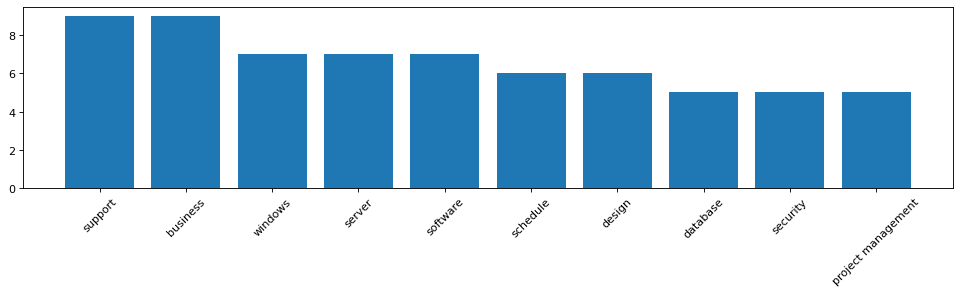

In [19]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 3), dpi=80)
plt.xticks(rotation = 45)

plt.bar(counting.keys(), counting.values())

### Entity Recognition

In [20]:
from spacy import displacy 

doc = nlp(df_resume.Clean_resume.iloc[0])

colors = {"SKILL": "linear-gradient(90deg, #aa9cfc, #fc9ce7)"}
options = {"colors": colors}

displacy.render(doc, style="ent", jupyter=True, options=options)

## 5. Let's load some PDF

In [21]:
#pip install PyPDF2

In [22]:
from PyPDF2 import PdfReader


reader = PdfReader("../data/someone_cv.pdf")
page = reader.pages[0] #first page just for demo
text = page.extract_text()


In [24]:
text = preprocessing(text)

In [25]:
doc = nlp(text)

displacy.render(doc, style="ent", jupyter=True, options=options)